In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions
from abtem import Potential, GridScan, PlaneWave, Probe, FrozenPhonons, WavesDetector, CTF, PixelatedDetector, LineScan, AnnularDetector
from abtem import show_atoms
from ase.io import read

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config

config.set({'device': 'gpu'})
config.set({'fft': 'mkl'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
Z = 8 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional

O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE', epsilon=1)

print('bound electron configuration:', O_transitions.bound_configuration)
print('ionic electron configuration:', O_transitions.excited_configuration)

bound electron configuration: 1s2 2s2 2p4
ionic electron configuration: 1s1 2s2 2p4


In [3]:
transition_potentials = O_transitions.get_transition_potentials(extent=2, gpts=128, energy=100e3)

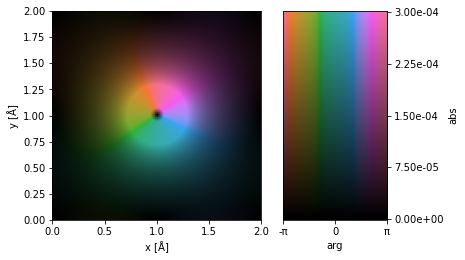

In [4]:
transition_images = transition_potentials.to_images()
transition_images[0].show(cbar=True, vmin=0, vmax=3e-4);

In [8]:
atoms = read('../data/srtio3_100.cif') * (1, 1, 1)

fp = FrozenPhonons(atoms, num_configs=1, sigmas=.0)
potential = Potential(fp, gpts=128, slice_thickness=1)

waves = Probe(energy=100e3, semiangle_cutoff=30, rolloff=0.)
waves.grid.match(potential)

detectors = [AnnularDetector(0, 30)]
scan = GridScan()

waves = waves.build(positions=scan, lazy=False)
measurements = waves.transition_multislice(potential, transition_potentials, detectors=detectors)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fca35d44340>)

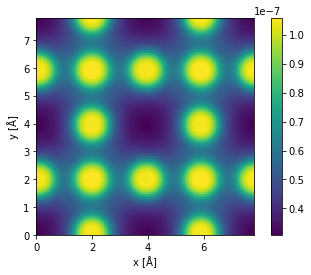

In [9]:
measurements.interpolate(.1).tile((2,2)).show(cbar=True)